In [0]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("../1stProject/data/목적별_국적별_입국.csv", encoding='cp949')

# "소 계" 포함된 행 제거
df_cleaned = df[~df.apply(lambda row: row.astype(str).str.contains("소 계").any(), axis=1)]

# 결과 저장
df_cleaned.to_csv("../1stProject/data/목적별_국적별_입국_소계제거.csv", index=False, encoding='cp949')


KeyboardInterrupt

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000022CB9910C10>>
Traceback (most recent call last):
  File "C:\Users\jangs\anaconda3\envs\project\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jangs\anaconda3\envs\project\Lib\threading.py", line 1501, in enumerate
    def enumerate():
    
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
import pandas as pd

df = pd.read_excel("../1stProject/data/목적별 국적별 입국_250709084025.xls", engine="xlrd")
df.to_csv("../1stProject/data/목적별_국적별_입국.csv", index=False, encoding="cp949")


In [5]:
import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import platform

# [1] 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# [2] 데이터 로딩 및 전처리
df = pd.read_csv('../1stProject/data/목적별_국적별_입국_소계제거.csv', encoding='cp949')
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")

# ⛔️ "입국자수"에 숫자가 아닌 값 필터링 제거
df = df[~df["입국자수"].str.contains("명|합계|소계|인원", na=False)]

# 날짜 및 수치형 변환
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df["입국자수"] = df["입국자수"].astype(str).str.replace(",", "").astype(float)

# 관광 목적만 필터링
df = df[df["목적"] == "관광"].sort_values("월").reset_index(drop=True)

# [3] Prophet용 데이터
df_prophet = df.groupby("월")["입국자수"].sum().reset_index()
df_prophet.columns = ["ds", "y"]

# [4] Prophet 모델 훈련 및 예측
prophet = Prophet(yearly_seasonality=True)
prophet.fit(df_prophet)
future = prophet.make_future_dataframe(periods=6, freq='MS')
forecast = prophet.predict(future)

# [5] XGBoost용 피처 생성
df_feat = df_prophet.copy()
df_feat["연도"] = df_feat["ds"].dt.year
df_feat["월"] = df_feat["ds"].dt.month
df_feat["계절"] = df_feat["월"] % 12 // 3
df_feat["전월입국자수"] = df_feat["y"].shift(1)
df_feat["전년동월입국자수"] = df_feat["y"].shift(12)
df_feat["전월증감률"] = df_feat["y"].pct_change().shift(1)
df_feat["전년증감률"] = (df_feat["y"] - df_feat["y"].shift(12)) / df_feat["y"].shift(12)
df_feat["이동평균"] = df_feat["y"].rolling(window=3).mean().shift(1)
df_feat = df_feat.replace([np.inf, -np.inf], np.nan).dropna()

# [6] XGBoost 모델 학습 및 예측
features = ["연도", "월", "계절", "전월입국자수", "전년동월입국자수", "전월증감률", "전년증감률", "이동평균"]
X = df_feat[features]
y = df_feat["y"]
X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# [7] 시각화
plt.figure(figsize=(14, 6))
plt.plot(df_feat["ds"], df_feat["y"], label="실제 입국자수", color='blue')
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet 예측", color='green', linestyle='--')
plt.plot(df_feat["ds"].iloc[-6:], y_pred, label="XGBoost 예측", color='orange', marker='o')
plt.axvline(df_feat["ds"].iloc[-7], color='gray', linestyle='--', label="예측 시작")
plt.title(f"입국자 수 예측 (Prophet + XGBoost 병렬)\nXGBoost RMSE: {rmse:.0f}")
plt.xlabel("월")
plt.ylabel("입국자 수")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ 사용 가능한 국적 목록:


TypeError: '<' not supported between instances of 'str' and 'float'

예측할 국적 입력 (전체 예측 원하면 Enter): 일본
예측할 목적 입력 (전체 예측 원하면 Enter): 관광
👉 입력한 국적과 유사한 값으로 '일  본' 사용
👉 입력한 목적과 유사한 값으로 '관광' 사용

📌 예측 대상: 일  본 / 관광 (92 개월치)


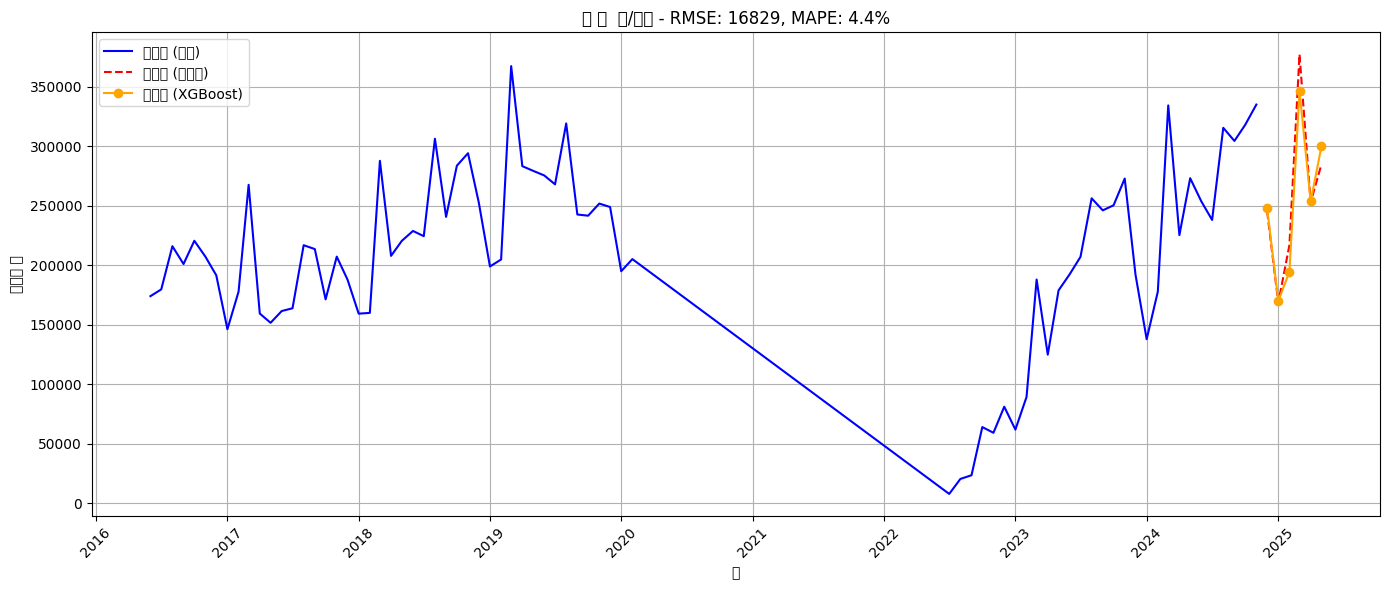

23:38:29 - cmdstanpy - INFO - Chain [1] start processing
23:38:30 - cmdstanpy - INFO - Chain [1] done processing


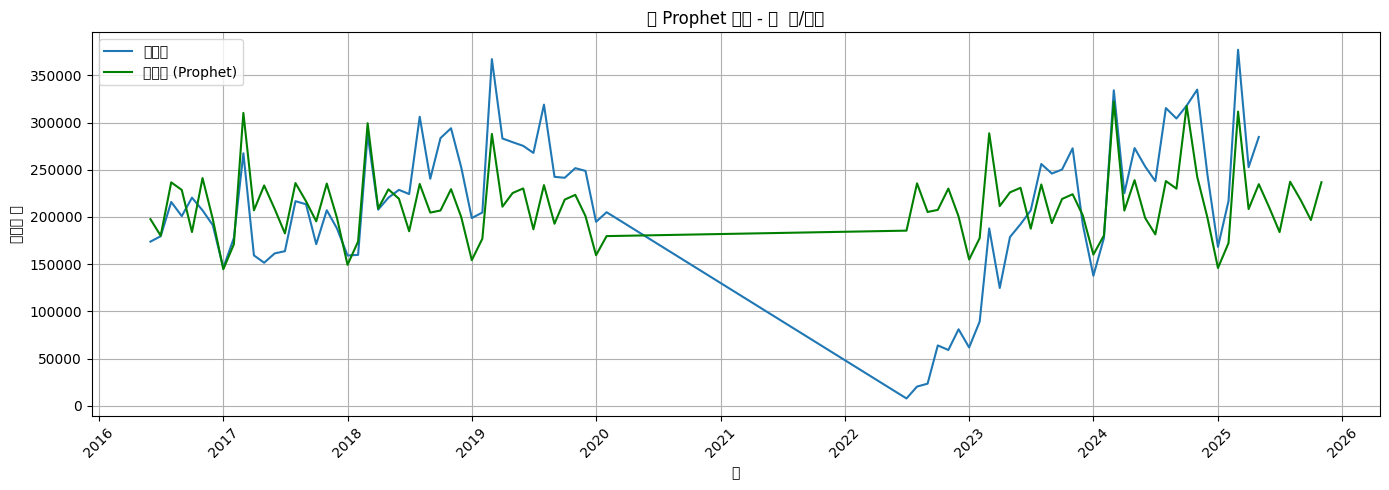

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

# 문자열 정규화 함수
def normalize(text):
    return text.replace(" ", "").lower()

# [1] 사용자 입력 및 유사 매칭
선택_국적 = input("예측할 국적 입력 (전체 예측 원하면 Enter): ").strip()
선택_목적 = input("예측할 목적 입력 (전체 예측 원하면 Enter): ").strip()

# [2] 데이터 로딩 및 전처리
df = pd.read_csv('../1stProject/data/목적별_국적별_입국_소계제거.csv', encoding='cp949')
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df["입국자수"] = pd.to_numeric(df["입국자수"].astype(str).str.replace(",", "", regex=False), errors="coerce")

# [3] 유사 국적/목적 자동 완성
if 선택_국적:
    match = [nat for nat in df["국적"].dropna().unique()
             if isinstance(nat, str) and normalize(선택_국적) in normalize(nat)]
    if match:
        선택_국적 = match[0]
        print(f"👉 입력한 국적과 유사한 값으로 '{선택_국적}' 사용")
    else:
        print("❌ 유효한 국적이 아닙니다."); 선택_국적 = ""

if 선택_목적:
    match = [pur for pur in df["목적"].dropna().unique()
             if isinstance(pur, str) and normalize(선택_목적) in normalize(pur)]
    if match:
        선택_목적 = match[0]
        print(f"👉 입력한 목적과 유사한 값으로 '{선택_목적}' 사용")
    else:
        print("❌ 유효한 목적이 아닙니다."); 선택_목적 = ""

# [4] 예측 대상 필터링
targets = df.groupby(["국적", "목적"]).size().reset_index().rename(columns={0: "count"})
valid_targets = targets[targets['count'] > 24]
if 선택_국적:
    valid_targets = valid_targets[valid_targets["국적"] == 선택_국적]
if 선택_목적:
    valid_targets = valid_targets[valid_targets["목적"] == 선택_목적]

# [5] 예측 루프
for idx, row in valid_targets.iterrows():
    국적, 목적 = row["국적"], row["목적"]
    df_filtered = df[(df["국적"] == 국적) & (df["목적"] == 목적)].sort_values("월").reset_index(drop=True)

    if len(df_filtered) < 30:
        continue
    print(f"\n📌 예측 대상: {국적} / {목적} ({len(df_filtered)} 개월치)")

    # 파생 변수 생성
    df_filtered["연도"] = df_filtered["월"].dt.year
    df_filtered["월_숫자"] = df_filtered["월"].dt.month
    df_filtered["계절"] = df_filtered["월"].dt.month % 12 // 3
    df_filtered["전월입국자수"] = df_filtered["입국자수"].shift(1)
    df_filtered["전년동월입국자수"] = df_filtered["입국자수"].shift(12)
    df_filtered["전월증감률"] = df_filtered["입국자수"].pct_change().shift(1)
    df_filtered["전년증감률"] = (df_filtered["입국자수"] - df_filtered["입국자수"].shift(12)) / df_filtered["입국자수"].shift(12)
    df_filtered["이동평균3"] = df_filtered["입국자수"].rolling(window=3).mean().shift(1)
    df_filtered["이동평균6"] = df_filtered["입국자수"].rolling(window=6).mean().shift(1)
    df_filtered["전월_차이"] = df_filtered["입국자수"] - df_filtered["전월입국자수"]
    df_filtered["전년_차이"] = df_filtered["입국자수"] - df_filtered["전년동월입국자수"]
    df_filtered["연중누적합"] = df_filtered.groupby("연도")["입국자수"].cumsum()
    df_filtered = df_filtered.replace([np.inf, -np.inf], np.nan).dropna().copy()

    if df_filtered.empty:
        continue

    # 특징 및 타겟
    features = ["연도", "월_숫자", "계절", "전월입국자수", "전년동월입국자수",
                "전월증감률", "전년증감률", "이동평균3", "이동평균6",
                "전월_차이", "전년_차이", "연중누적합"]
    X = df_filtered[features]
    y = df_filtered["입국자수"]
    dates = df_filtered["월"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 학습/테스트 분리
    X_train, X_test = X_scaled[:-6], X_scaled[-6:]
    y_train, y_test = y[:-6], y[-6:]
    dates_train, dates_test = dates[:-6], dates[-6:]

    if len(X_test) == 0:
        continue

    # GPU XGBoost 모델 및 튜닝
    xgb = XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, random_state=42)
    param_dist = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10,
                                 cv=TimeSeriesSplit(n_splits=3),
                                 scoring='neg_root_mean_squared_error', random_state=42)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    y_pred = np.clip(best_model.predict(X_test), 0, None)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    # 시각화
    plt.figure(figsize=(14, 6))
    plt.plot(dates_train, y_train, label="실제값 (학습)", color='blue')
    plt.plot(dates_test, y_test, label="실제값 (테스트)", color='red', linestyle='--')
    plt.plot(dates_test, y_pred, label="예측값 (XGBoost)", color='orange', marker='o')
    plt.title(f"📊 {국적}/{목적} - RMSE: {rmse:.0f}, MAPE: {mape:.1f}%")
    plt.xlabel("월")
    plt.ylabel("입국자 수")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Prophet 시계열 예측
    df_prophet = df_filtered[["월", "입국자수"]].rename(columns={"월": "ds", "입국자수": "y"})
    prophet = Prophet(yearly_seasonality=True)
    try:
        prophet.add_country_holidays(country_name='KR')
        prophet.fit(df_prophet)
        future = prophet.make_future_dataframe(periods=6, freq='MS')
        forecast = prophet.predict(future)

        plt.figure(figsize=(14, 5))
        plt.plot(df_prophet['ds'], df_prophet['y'], label='실제값')
        plt.plot(forecast['ds'], forecast['yhat'], label='예측값 (Prophet)', color='green')
        plt.title(f"🔮 Prophet 예측 - {국적}/{목적}")
        plt.xlabel("월")
        plt.ylabel("입국자 수")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[Prophet 오류] {국적}/{목적}: {e}")
